# Comparison of DOF between rigid and scheimpflug camera

In [263]:
from __future__ import print_function, division
import numpy as np
import numpy.linalg as linalg
from math import tan, pi, atan, cos, sin, asin
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1.inset_locator import BboxConnector
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from scipy.interpolate import interp1d
from scipy.misc import imread as imread
from warnings import warn

# For IPython interactive widgets
from ipywidgets import interact, interactive, FloatSlider 
from IPython.display import display, Image

# Local libraries
import iutils.optics.fourier as fou
import iutils.optics.goptics as gou
import iutils.plot.mplutils as mpu

In [2]:
%matplotlib inline

TO DO##

1. In the implementation of the function get_zo() what happens if zodash*cosd(alpha) < f ?


In [14]:
# Helper functions
tand = lambda angle: tan(pi*angle/180.0)
cosd = lambda angle: cos(pi*angle/180.0)
sind = lambda angle: sin(pi*angle/180.0)
arctand = lambda x : np.rad2deg(np.arctan(x))

def is_even(num):
    return num%2 == 0

def get_points(angleY, xo, ymin=-100, ymax=10, n=10):
    """angleY: angle w.r.t. the y-axis in degrees"""
    y = np.linspace(ymin, ymax, n)
    x = xo + y*tand(angleY)
    return x, y

def get_zo(f, zodash, alpha):
    """alpha: angle w.r.t y axis for scheimpflug camera"""
    deno = zodash*cosd(alpha)  - f
    if deno < 0:
        warn('Expecting zodash*cos(alpha) > f but it turned out to be otherwise')
    return -(zodash*f)/deno

def beta(f, zo, alpha):
    """returns angle of PoSF for scheimpflug camera"""
    return arctand((abs(zo)/f)*sind(alpha))  # why the explicity abs???

# the derivation of the formulae are in onenote (but very similar to the ones in wikipedia)
def geo_depth_of_focus_limits(u, f, c, N):
    """returns depth of focus limits in the image space
    
    @params: u: (float) object plane distance
    @params: f: (float) focal length
    @params: c: (float) circle of confusion
    @params: N: (float) F/# defined at infinite focus
    @returns: vf: (float) far limit of depth of focus
    @returns: vn: (float) near limit of depth of focus 
    
    Note: vn > vf
    """
    vf = (u*f**2)/((f + c*N)*(u-f))
    vn = (u*f**2)/((f - c*N)*(u-f))
    return vf, vn

def geo_depth_of_field_limits(u, f, c, N):
    """returns the depth of field limits in the object space

    @params: u: (float) object plane distance
    @params: f: (float) focal length
    @params: c: (float) circle of confusion
    @params: N: (float) F/# defined at infinite focus
    @returns: df: (float) far limit of depth of field
    @returns: dn: (float) near limit of depth of field
    
    Note: df > dn
    """
    df = (u*f**2)/(f**2 - c*N*(u - f))
    dn = (u*f**2)/(f**2 + c*N*(u - f))
    return df, dn

# helper function to draw objects
def draw_objects(ax, locations, sizes):
    for loc, size in zip(locations, sizes):
        ax.add_patch(
            patches.Rectangle(
                (loc[0], loc[1]),   # (x,y)
                size[0], size[1], fill=True, facecolor='#F79F79', edgecolor='#888888', zorder=1))
        
def set_axes_edge_color_and_width(ax, col, width=1):
    """sets the edge color of axes"""
    for each in ['bottom', 'top', 'right', 'left']:
        if col == 'none':
            ax.spines[each].set_visible(False)
        else:
            ax.spines[each].set_color(col)
        ax.spines[each].set_linewidth(width)


In [265]:
# Optical system (for both rigid and scheimpflug camera)

zodash = 31.57894736842105 #30    # Lens to image plane distance
f = 15         # Focal length
fnum = 2.5     # Aperture
pixel_size = 0.00178  # pixel size (used as Circle of confusion for DOF)
coc = 1/50
print('coc = ', coc)

# for perfect imaging at u = 1000 
print(gou.gaussian_lens_formula(u=1000, v=None, f=f))

# imaging specified by image plane distance for the plots
print(gou.gaussian_lens_formula(u=None, v=zodash, f=f))

# imaging specified by image plane distance for the plots
print(gou.gaussian_lens_formula(u=100, v=None, f=f))

coc =  0.02
glfParams(u=1000, v=15.228426395939087, f=15)
glfParams(u=28.571428571428573, v=31.57894736842105, f=15)
glfParams(u=100, v=17.647058823529413, f=15)


## DOF map for Scheimpflug camera

uo = 100.0


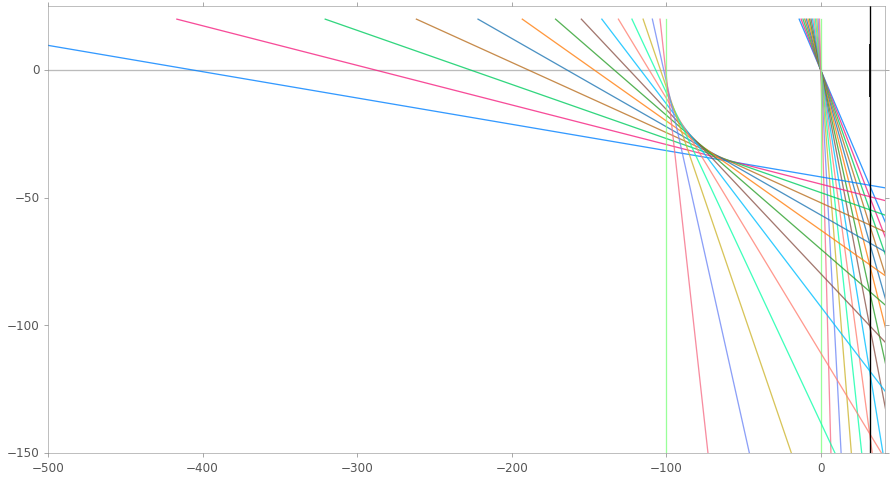

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
cols = ['#0080FF', '#F52080', '#00CC60', '#B96F20', '#1f77b4', 
        '#ff7f0e', '#2ca02c', '#8c564b', '#00BFFF', '#FF8073',
        '#11FFAA', '#CEb631', '#7088F6', '#f67088', '#80FF80', 
        '#EAC910', '#38A7D0', '#f34060', '#40d370', '#CE8f31', 
        '#2166AC', '#B2182B', '#32b135', '#814D16', '#606060',
        '#0080FF', '#F52080', '#00CC60', '#B96F20', '#1f77b4', 
        '#ff7f0e', '#2ca02c', '#8c564b', '#00BFFF', '#FF8073',
        '#11FFAA', '#CEb631', '#7088F6', '#f67088', '#80FF80', 
        '#EAC910', '#38A7D0', '#f34060', '#40d370', '#CE8f31', 
        '#2166AC', '#B2182B', '#32b135', '#814D16', '#606060']

# CHANGE FOCAL LENGTH
f = 24.

ymin, ymax = -150, 25
#ymin, ymax = -150, 150
uo = gou.gaussian_lens_formula(u=None, v=zodash, f=f).u
print('uo =', uo)
ax.set_xlim(-500, zodash + 10)
ax.set_ylim(ymin, ymax)
ax.axhline(color='#BBBBBB',)

# Draw image plane
ax.axvline(x=zodash, ymin=ymin, ymax=ymax, color='#CCCCCC')
x, y = get_points(0, zodash, -10, 10)
ax.plot(x, y, color='#222222', lw=2,)

# Draw lens plane
alpha = np.linspace(-35, 0, 15)
for i, each in enumerate(alpha):
    x, y = get_points(each, 0, ymin, ymax-5)
    ax.plot(x, y, color=cols[i], alpha=0.8)
# Draw object plane
for i, each in enumerate(alpha):
    zo = get_zo(f, zodash, each)
    #print('zo = ', zo)
    angleY = beta(f, zo, each)
    x, y = get_points(angleY, zo, ymin, ymax-5)
    ax.plot(x, y, color=cols[i], alpha=0.8)
ax.axvline(color='#000000', x=zodash)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
f = 24.

ymin, ymax = -150, 25
uo = gou.gaussian_lens_formula(u=None, v=zodash, f=f).u
print('uo =', uo)
ax.set_xlim(-500, zodash + 10)
ax.set_ylim(ymin, ymax)
ax.axhline(color='#BBBBBB',)

# Draw image plane
ax.axvline(x=zodash, ymin=ymin, ymax=ymax, color='#CCCCCC')
x, y = get_points(0, zodash, -10, 10)
ax.plot(x, y, color='#222222', lw=2,)

# Draw lens plane
alpha = np.linspace(-35, 0, 15)
for i, each in enumerate(alpha):
    x, y = get_points(each, 0, ymin, ymax-5)
    ax.plot(x, y, color=cols[i], alpha=0.8)
# Draw object plane
for i, each in enumerate(alpha):
    zo = get_zo(f, zodash, each)
    #print('zo = ', zo)
    angleY = beta(f, zo, each)
    x, y = get_points(angleY, zo, ymin, ymax-5)
    ax.plot(x, y, color=cols[i], alpha=0.8)
ax.axvline(color='#000000', x=zodash)
plt.show()

alpha = -40.385 beta = -89.8489651051
alpha = -40.09875 beta = -89.5609811142
alpha = -39.8125 beta = -89.2712792345
alpha = -39.52625 beta = -88.9798288163
alpha = -39.24 beta = -88.6865985233


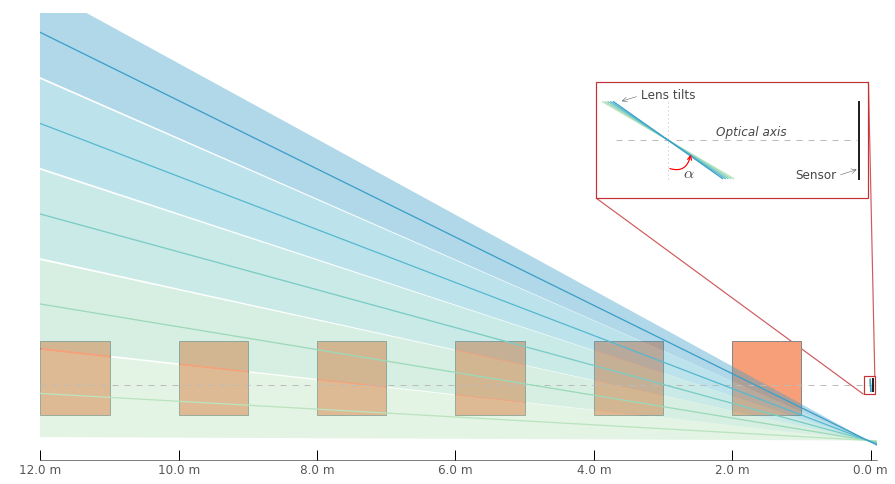

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
num = 5

f = 24

#ccmap = plt.cm.plasma
#cindex = np.linspace(0, ccmap.N-40, num)
ccmap = plt.cm.GnBu
cindex = np.linspace(80, ccmap.N-80, num)
cols = [ccmap(int(i)) for i in cindex]

ymin, ymax = -50, 250
uo = 100
zodash = gou.gaussian_lens_formula(u=uo, v=None, f=f).v
zodash_far, zodash_near = geo_depth_of_focus_limits(u=uo, f=f, c=coc, N=fnum)
#print('zodash = ', zodash,  'vf = ', vf, 'vn =', vn)

ax.set_xlim(-12000, 100)
ax.set_ylim(ymin, ymax)
ax.axhline(color='#BBBBBB', lw=1.0, linestyle='dashed')   # optical axis

# Draw image plane
x, y = get_points(0, zodash, -4, 4)
ax.plot(x, y, color='#222222', lw=2,)

# Draw lens plane
alpha = np.linspace(-40.385, -39.24, num)

for i, each in enumerate(alpha):
    x, y = get_points(each, 0, -4, 4)
    ax.plot(x, y, color=cols[i], alpha=1.0)
    
# Draw object plane
ypad = 100 # the pad is needed to ensure that the regions within the visible
           # canvas are appropriately filled
for i, each in enumerate(alpha):
    #print('alpha = ', each)
    zo = get_zo(f, zodash, each)
    #print('zo = ', zo)
    angleY = beta(f, zo, each)
    print('alpha =', each, 'beta =', angleY)
    x, y = get_points(angleY, zo, ymin-ypad, ymax+ypad)
    ax.plot(x, y, color=cols[i], alpha=1.0)
    # Draw DOF wedge
    # near
    zo_near = get_zo(f, zodash_near, each)
    angleY_near = beta(f, zo_near, each)
    xn, yn = get_points(angleY_near, zo_near, ymin-ypad, ymax+ypad)
    #ax.plot(xn, yn, color=cols[i], alpha=0.5)
    # far
    zo_far = get_zo(f, zodash_far, each)
    angleY_far = beta(f, zo_far, each)
    xf, yf = get_points(angleY_far, zo_far, ymin-ypad, ymax+ypad)
    #ax.plot(xf, yf, color=cols[i], alpha=0.5)
    
    if each: # currently the following block of code assumes that the alpha is -ve
        # fill the region between far and near 
        posf_near = interp1d(xn, yn)
        posf_far = interp1d(xf, yf)
        x_fill_start = min(xn[0], xf[0])
        x_fill_end = max(xn[-1], xf[-1]) 
        x_fill = np.linspace(x_fill_start, x_fill_end, 10)
        y_fill_near = posf_near(x_fill)
        y_fill_far = posf_far(x_fill)
        ax.fill_between(x=x_fill, y1=y_fill_near, y2=y_fill_far,
                        facecolor=cols[i], edgecolor='none', alpha=0.4, zorder=2)
    else:
        ax.fill_between(x=[xf[0], xn[0]], y1=ymin, y2=ymax, 
                        facecolor=cols[i], edgecolor='none', alpha=0.4, zorder=2)
        
draw_objects(ax, 
             locations=((-2000, -20), (-4000, -20), (-6000, -20), (-8000, -20), (-10000, -20), (-12000, -20),), 
             sizes=((1000, 50), (1000, 50), (1000, 50), (1000, 50), (1000, 50), (1000, 50),) )

# Add inset figure to show zoomed in version of the lens and sensor configuration
# -------------------------------------------------------------------------------
inset_rect = [0.64, 0.58, 0.25, 0.2]
inset_ax = fig.add_axes(inset_rect, frameon=False)
#set_axes_edge_color_and_width(inset_ax, '#c43235', 1.2)
inset_ax.set_xlim(-4, 10)
inset_ymin, inset_ymax = -6, 6
inset_ax.set_ylim(inset_ymin, inset_ymax)
#inset_ax.axhline(color='#BBBBBB', lw=1.0, linestyle='dashed')   # optical axis

inset_ax.plot([-3, 9.5], [0, 0], color='#BBBBBB', lw=1.0, linestyle='dashed')  # optical axis

# draw image plane
inset_img_plane_x = zodash-22 #  compressed the length by subtracting -22 (plot is obviously not to scale)
x, y = get_points(0, inset_img_plane_x, -4, 4)  
inset_ax.plot(x, y, color='#222222', lw=2,)

# draw lens configurations
inset_enp_x = -0.3
x, y = get_points(0, inset_enp_x, -4, 4)
inset_ax.plot(x, y, color='#BBBBBB', lw=1.0, linestyle='dotted')
for i, each in enumerate(alpha + np.arange(len(alpha))):
    x, y = get_points(each, -0.3, -4, 4)
    inset_ax.plot(x, y, color=cols[i])
    
# remove ticks 
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# create rect patch for the inset
inset_dst_rect = patches.Rectangle((-3970, 126), 3940, 78, fill=False, edgecolor='#c43235', zorder=15, lw=1.2)
ax.add_patch(inset_dst_rect)

# add inset_axis around the lens and sensor in the main axes
inset_source_rect = patches.Rectangle((-100, -6),   # (x,y)
                              162, 12, fill=False, edgecolor='#c43235', zorder=15, lw=1.2)
ax.add_patch(inset_source_rect)

src_bbox = inset_source_rect.get_bbox()
dst_bbox = inset_dst_rect.get_bbox() 

path1 = BboxConnector.connect_bbox(bbox1=src_bbox, bbox2=dst_bbox, loc1=3, loc2=3)
path1_patch = patches.PathPatch(path1, color='#c43235', lw=1.2, alpha=0.8, zorder=0)
ax.add_patch(path1_patch)
path2 = BboxConnector.connect_bbox(bbox1=src_bbox, bbox2=dst_bbox, loc1=1, loc2=1)
path2_patch = patches.PathPatch(path2, color='#c43235', alpha=0.8, lw=1.2, zorder=0)
ax.add_patch(path2_patch)

# set spines and tick properties

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks([]) # it's also making the inset_axes' left spine vanish!!!!
ax.yaxis.set_tick_params(which='both', color='none')
for ytl in ax.get_yticklabels():
    ytl.set_color('none')
    
ax.xaxis.set_tick_params(which='major', direction='in', color='k', length=10, width=1.)
sign = lambda x : -1 if x < 0 else 1
tic_locs = ax.xaxis.get_ticklocs()[:-1]  # for some reason the last tick was at 2 on the image side
tic_lables = ['{:0.1f} m'.format(sign(each)*each/(1000)) for each in tic_locs ]
ax.set_xticklabels(tic_lables)
ax.set_xticks(tic_locs)

# annotations in inset axes
inset_ax.text(x=inset_enp_x + 2.5, y=0.5, s='Optical axis', fontsize=12, fontstyle='italic')
inset_ax.annotate('Sensor', (inset_img_plane_x, -3), (inset_img_plane_x - 3.3, -4), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.5, color='#555555',  relpos=(0.8,0.2)))
inset_ax.annotate('Lens tilts', (inset_enp_x - 2.5, 4), (inset_enp_x - 1.4, 4.3), fontsize=12,
                 arrowprops=dict(arrowstyle="->", linewidth=0.5, color='#555555',  relpos=(0.0,0.5)))
inset_ax.annotate('', (inset_enp_x+1.2, -1.3), (inset_enp_x, -2.9), 
                  arrowprops=dict(arrowstyle="->", color='red', lw=1.2,
                                  connectionstyle="angle3,angleA=-20,angleB=-100"))
inset_ax.text(x=inset_enp_x + 0.8, y= -3.9, s=r'$\alpha$', fontsize=16)

plt.show()

## DOF map for Rigid camera

The DOF calculations are based on geometric DOF expressions derived using similar triangle geometry. It doesn't take diffraction into account. The CoC (circle of confusion) is equal to the pixel size.

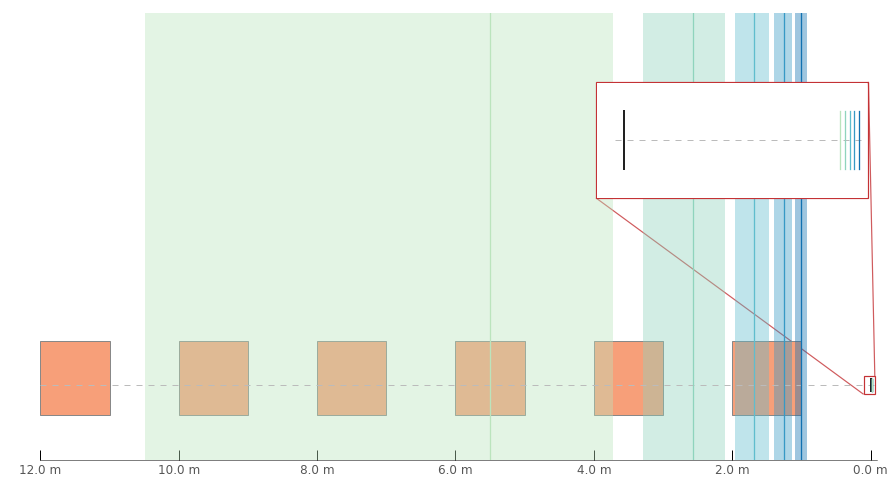

In [69]:
num = 5

u_start = 1000
u_end = 5500

v_start = gou.gaussian_lens_formula(u=u_start, v=None, f=f).v
v_end = gou.gaussian_lens_formula(u=u_end, v=None, f=f).v

#print('v_start =', v_start, 'v_end =', v_end)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ymin, ymax = -50, 250
ax.set_xlim(-12000, 100)
ax.set_ylim(ymin, ymax)
ax.axhline(color='#BBBBBB', lw=1.0, linestyle='dashed')   # optical axis

#ax.set_yticks([])

#ccmap = plt.cm.plasma
#cindex = np.linspace(0, ccmap.N-40, num)
ccmap = plt.cm.GnBu_r
cindex = np.linspace(40, ccmap.N-80, num)
cols = [ccmap(int(i)) for i in cindex]

# draw lens plane
x, y = get_points(0, 0, -4, 4)
ax.plot(x, y, color='#222222', lw=2,)

for i, v in enumerate(np.linspace(v_start, v_end, num)):
    u = gou.gaussian_lens_formula(u=None, v=v, f=f).u
    #print('v =', v, '; u =', u)
    df, dn = geo_depth_of_field_limits(u, f, coc, fnum)
    # Draw image plane
    x, y = get_points(angleY=0, xo=v, ymin=-4, ymax=4)
    ax.plot(x, y, color=cols[i], alpha=1)
    # Draw the object plane
    x, y = get_points(angleY=0, xo=-u, ymin=ymin, ymax=ymax)
    ax.plot(x, y, color=cols[i], alpha=1) 
    # Draw DOF region
    # far
    xf, yf = get_points(angleY=0, xo=-df, ymin=ymin, ymax=ymax)
    # near
    xn, yn = get_points(angleY=0, xo=-dn, ymin=ymin, ymax=ymax)   
    # fill
    ax.fill_between(x=[xf[0], xn[0]], y1=ymin, y2=ymax, facecolor=cols[i], edgecolor='none', alpha=0.4, zorder=2)
#
draw_objects(ax, 
             locations=((-2000, -20), (-4000, -20), (-6000, -20), (-8000, -20), (-10000, -20), (-12000, -20),), 
             sizes=((1000, 50), (1000, 50), (1000, 50), (1000, 50), (1000, 50), (1000, 50),) )

# Add inset figure to show zoomed in version of the lens and sensor configuration
# -------------------------------------------------------------------------------
inset_rect = [0.64, 0.58, 0.25, 0.2]
inset_ax = fig.add_axes(inset_rect, axisbg='white', frameon=True)
set_axes_edge_color_and_width(inset_ax, 'none')
inset_ax.set_xlim(10, 25)
inset_ymin, inset_ymax = -8, 8
inset_ax.set_ylim(inset_ymin, inset_ymax)
#inset_ax.axhline(color='#BBBBBB', lw=1.0, linestyle='dashed')   # optical axis
inset_ax.plot([11., 24.85], [0, 0], color='#BBBBBB', lw=1.0, linestyle='dashed')  # optical axis

# lens plane
x, y = get_points(0, 11.5, -4, 4)
inset_ax.plot(x, y, color='#222222', lw=2,)
# Draw image planes
img_dist = np.linspace(v_start, v_end, num)
for i, v in enumerate(img_dist + -0.15*np.arange(len(img_dist))):
    x, y = get_points(angleY=0, xo=v, ymin=-4, ymax=4)
    inset_ax.plot(x, y, color=cols[i], alpha=1)
# remove ticks 
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# create rect patch for the inset
inset_dst_rect = patches.Rectangle((-3970, 126), 3940, 78, fill=False, edgecolor='#c43235', zorder=15, lw=1.2)
ax.add_patch(inset_dst_rect)

# add inset_axis around the lens and sensor in the main axes
inset_source_rect = patches.Rectangle((-100, -6),   # (x,y)
                              162, 12, fill=False, edgecolor='#c43235', zorder=15, lw=1.2)
ax.add_patch(inset_source_rect)

src_bbox = inset_source_rect.get_bbox()
dst_bbox = inset_dst_rect.get_bbox() 

path1 = BboxConnector.connect_bbox(bbox1=src_bbox, bbox2=dst_bbox, loc1=3, loc2=3)
path1_patch = patches.PathPatch(path1, color='#c43235', lw=1.2, alpha=0.8, zorder=0)
ax.add_patch(path1_patch)
path2 = BboxConnector.connect_bbox(bbox1=src_bbox, bbox2=dst_bbox, loc1=1, loc2=1)
path2_patch = patches.PathPatch(path2, color='#c43235', alpha=0.8, lw=1.2, zorder=0)
ax.add_patch(path2_patch)

# set spines and tick properties

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks([]) # it's also making the inset_axes' left spine vanish!!!!
ax.yaxis.set_tick_params(which='both', color='none')
for ytl in ax.get_yticklabels():
    ytl.set_color('none')
    
ax.xaxis.set_tick_params(which='major', direction='in', color='k', length=10, width=1.)
sign = lambda x : -1 if x < 0 else 1
tic_locs = ax.xaxis.get_ticklocs()[:-1]  # for some reason the last tick was at 2 on the image side
tic_lables = ['{:0.1f} m'.format(sign(each)*each/(1000)) for each in tic_locs ]
ax.set_xticklabels(tic_lables)
ax.set_xticks(tic_locs)

plt.show()

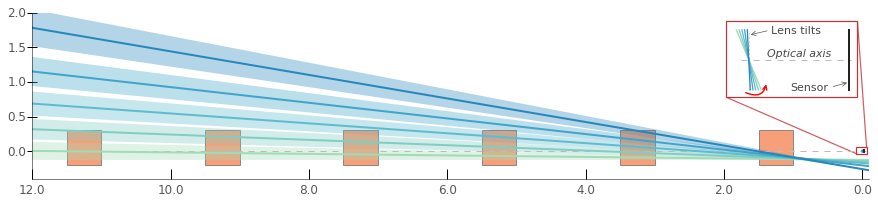

In [413]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
num = 5

f = 24

#ccmap = plt.cm.plasma
#cindex = np.linspace(0, ccmap.N-40, num)
ccmap = plt.cm.GnBu
cindex = np.linspace(100, ccmap.N-60, num)
cols = [ccmap(int(i)) for i in cindex]

ymin, ymax = -400, 2000
uo = 1200
zodash = gou.gaussian_lens_formula(u=uo, v=None, f=f).v
zodash_far, zodash_near = geo_depth_of_focus_limits(u=uo, f=f, c=coc, N=fnum)
#print('zodash = ', zodash,  'vf = ', vf, 'vn =', vn)

ax.set_xlim(-12000, 100)
ax.set_ylim(ymin, ymax)
ax.axhline(color='#BBBBBB', lw=1.0, linestyle='dashed')   # optical axis

# Draw image plane
x, y = get_points(0, zodash, -10, 10)
ax.plot(x, y, color='#222222', lw=2,)

# Draw lens plane
#alpha = np.linspace(-40.385, -39.24, num)

alpha = np.linspace(-10.87, -5.3, num)

for i, each in enumerate(alpha):
    x, y = get_points(each, 0, -10, 10)
    ax.plot(x, y, color=cols[i], alpha=1.0)
    
# Draw object plane
ypad = 100 # the pad is needed to ensure that the regions within the visible
           # canvas are appropriately filled
for i, each in enumerate(alpha):
    #print('alpha = ', each)
    zo = get_zo(f, zodash, each)
    #print('zo = ', zo)
    angleY = beta(f, zo, each)
    #print('alpha =', each, 'beta =', angleY)
    x, y = get_points(angleY, zo, ymin-ypad, ymax+ypad)
    ax.plot(x, y, color=cols[i], alpha=1.0, lw=2)
    # Draw DOF wedge
    # near
    zo_near = get_zo(f, zodash_near, each)
    angleY_near = beta(f, zo_near, each)
    xn, yn = get_points(angleY_near, zo_near, ymin-ypad, ymax+ypad)
    #ax.plot(xn, yn, color=cols[i], alpha=0.5)
    # far
    zo_far = get_zo(f, zodash_far, each)
    angleY_far = beta(f, zo_far, each)
    xf, yf = get_points(angleY_far, zo_far, ymin-ypad, ymax+ypad)
    #ax.plot(xf, yf, color=cols[i], alpha=0.5)
    
    if each: # currently the following block of code assumes that the alpha is -ve
        # fill the region between far and near 
        posf_near = interp1d(xn, yn)
        posf_far = interp1d(xf, yf)
        x_fill_start = min(xn[0], xf[0])
        x_fill_end = max(xn[-1], xf[-1]) 
        x_fill = np.linspace(x_fill_start, x_fill_end, 10)
        y_fill_near = posf_near(x_fill)
        y_fill_far = posf_far(x_fill)
        ax.fill_between(x=x_fill, y1=y_fill_near, y2=y_fill_far,
                        facecolor=cols[i], edgecolor='none', alpha=0.35, zorder=2)
    else:
        ax.fill_between(x=[xf[0], xn[0]], y1=ymin, y2=ymax, 
                        facecolor=cols[i], edgecolor='none', alpha=0.35, zorder=2)
        
draw_objects(ax, 
             locations=((-1500, -200), (-3500, -200), (-5500, -200), (-7500, -200), (-9500, -200), (-11500, -200),), 
             sizes=((500, 500), (500, 500), (500, 500), (500, 500), (500, 500), (500, 500),) )


# Add inset figure to show zoomed in version of the lens and sensor configuration
# -------------------------------------------------------------------------------
inset_rect = [0.769, 0.51, 0.12, 0.13]
inset_ax = fig.add_axes(inset_rect, frameon=False)
inset_ax.set_xlim(0, 8)
inset_ymin, inset_ymax = -5, 5
inset_ax.set_ylim(inset_ymin, inset_ymax)
inset_ax.plot([0.85,7.6], [0, 0], color='#BBBBBB', lw=1.0, linestyle='dashed')  # optical axis

# draw image plane
inset_img_plane_x = zodash-17 #  compressed the length by subtracting -22 (plot is obviously not to scale)
x, y = get_points(0, inset_img_plane_x, -4, 4)  
inset_ax.plot(x, y, color='#222222', lw=2,)

# draw lens configurations
inset_enp_x = 1.3
x, y = get_points(0, inset_enp_x, -4, 4)
inset_ax.plot(x, y, color='#BBBBBB', lw=1.0, linestyle='dotted')
for i, each in enumerate(alpha + np.arange(len(alpha))):
    x, y = get_points(each, inset_enp_x, -4, 4)
    inset_ax.plot(x, y, color=cols[i])
    
# remove ticks 
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# create rect patch for the inset
inset_dst_rect = patches.Rectangle((-1970, 780), 1900, 1100, fill=False, edgecolor='#c43235', zorder=15, lw=1.2)
ax.add_patch(inset_dst_rect)

# add inset_axis around the lens and sensor in the main axes
inset_source_rect = patches.Rectangle((-88, -36), 150, 90, fill=False, edgecolor='#c43235', zorder=15, lw=1.2)
ax.add_patch(inset_source_rect)

src_bbox = inset_source_rect.get_bbox()
dst_bbox = inset_dst_rect.get_bbox() 

path1 = BboxConnector.connect_bbox(bbox1=src_bbox, bbox2=dst_bbox, loc1=3, loc2=3)
path1_patch = patches.PathPatch(path1, color='#c43235', lw=1.2, alpha=0.8, zorder=0)
ax.add_patch(path1_patch)
path2 = BboxConnector.connect_bbox(bbox1=src_bbox, bbox2=dst_bbox, loc1=1, loc2=1)
path2_patch = patches.PathPatch(path2, color='#c43235', alpha=0.8, lw=1.2, zorder=0)
ax.add_patch(path2_patch)

# set spines and tick properties
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.xaxis.set_ticks_position('bottom')
ax.spines['left'].set_color('k')
ax.yaxis.set_ticks_position('left')
    
ax.xaxis.set_tick_params(which='major', direction='in', color='k', length=10, width=1., zorder=20)
sign = lambda x : -1 if x < 0 else 1
tic_locs = ax.xaxis.get_ticklocs()[:-1]  # for some reason the last tick was at 2 on the image side
tic_lables = ['{:0.1f}'.format(sign(each)*each/(1000)) for each in tic_locs ]
ax.set_xticklabels(tic_lables)
ax.set_xticks(tic_locs)

ax.yaxis.set_tick_params(which='major', direction='inout', color='k', length=10, width=1., zorder=20)
tic_locs = ax.yaxis.get_ticklocs()[1:]
#print(tic_locs)
tic_lables = ['{:0.1f}'.format(each/(1000)) for each in tic_locs ]
ax.set_yticklabels(tic_lables)
ax.set_yticks(tic_locs)


# annotations in inset axes
inset_ax.text(x=inset_enp_x + 1.12, y=0.5, s='Optical axis', fontsize=11, fontstyle='italic')
inset_ax.annotate('Sensor', (inset_img_plane_x, -3), (inset_img_plane_x - 3.6, -4), fontsize=11, 
                arrowprops=dict(arrowstyle="->", linewidth=0.7, color='#505050',  relpos=(0.8,0.2)))
inset_ax.annotate('Lens tilts', (inset_enp_x, 3.3), (inset_enp_x + 1.4, 3.6), fontsize=11,
                 arrowprops=dict(arrowstyle="->", linewidth=0.7, color='#555555',  relpos=(0.0,0.5)))
inset_ax.annotate('', (inset_enp_x+1.1, -3), (inset_enp_x-0.3, -4.28), 
                  arrowprops=dict(arrowstyle="->", color='red', lw=1.4,
                                  connectionstyle="angle3,angleA=-25,angleB=-100"))
#inset_ax.text(x=inset_enp_x + 0.8, y= -3.9, s=r'$\alpha$', fontsize=16)

ax.set_aspect('equal')

plt.show()

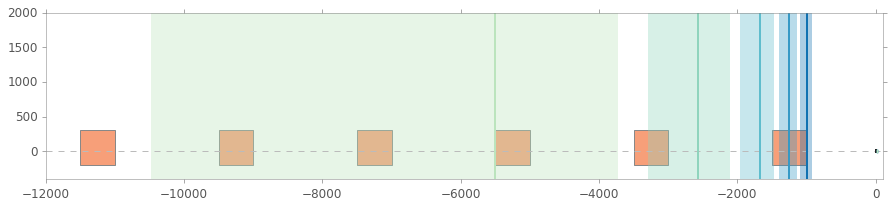

In [260]:
num = 5

u_start = 1000
u_end = 5500

v_start = gou.gaussian_lens_formula(u=u_start, v=None, f=f).v
v_end = gou.gaussian_lens_formula(u=u_end, v=None, f=f).v

#print('v_start =', v_start, 'v_end =', v_end)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ymin, ymax = -400, 2000
ax.set_xlim(-12000, 100)
ax.set_ylim(ymin, ymax)
ax.axhline(color='#BBBBBB', lw=1.0, linestyle='dashed')   # optical axis

#ax.set_yticks([])

#ccmap = plt.cm.plasma
#cindex = np.linspace(0, ccmap.N-40, num)
ccmap = plt.cm.GnBu_r
cindex = np.linspace(40, ccmap.N-80, num)
cols = [ccmap(int(i)) for i in cindex]

# draw lens plane
x, y = get_points(0, 0, -10, 10)
ax.plot(x, y, color='#222222', lw=2,)

for i, v in enumerate(np.linspace(v_start, v_end, num)):
    u = gou.gaussian_lens_formula(u=None, v=v, f=f).u
    #print('v =', v, '; u =', u)
    df, dn = geo_depth_of_field_limits(u, f, coc, fnum)
    # Draw image plane
    x, y = get_points(angleY=0, xo=v, ymin=-10, ymax=10)
    ax.plot(x, y, color=cols[i], alpha=1)
    # Draw the object plane
    x, y = get_points(angleY=0, xo=-u, ymin=ymin, ymax=ymax)
    ax.plot(x, y, color=cols[i], alpha=1, lw=2) 
    # Draw DOF region
    # far
    xf, yf = get_points(angleY=0, xo=-df, ymin=ymin, ymax=ymax)
    # near
    xn, yn = get_points(angleY=0, xo=-dn, ymin=ymin, ymax=ymax)   
    # fill
    ax.fill_between(x=[xf[0], xn[0]], y1=ymin, y2=ymax, facecolor=cols[i], edgecolor='none', alpha=0.35, zorder=2)

draw_objects(ax, 
             locations=((-1500, -200), (-3500, -200), (-5500, -200), (-7500, -200), (-9500, -200), (-11500, -200),), 
             sizes=((500, 500), (500, 500), (500, 500), (500, 500), (500, 500), (500, 500),) )


ax.set_aspect('equal')

plt.show()